# Modelo AutoRegresivo Integrado con Media Movil ARIMA

### Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
import sqlalchemy as db

### Conexión a BBDD y Llamado de Datos

In [3]:
tabla='2828hk'
conn = mysql.connector.connect(user='root', password='', host='localhost', database='stock_exchange')
stock = pd.DataFrame(pd.read_sql("SELECT * FROM "+tabla, conn))
conn.close()
stock.head(5)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,index,Date,Open,High,Low,Close,Volume
0,0,2019-01-02,102.800003,102.800003,99.250000,99.500000,12118897
1,1,2019-01-03,99.949997,100.400002,98.849998,99.599998,3562140
2,2,2019-01-04,99.000000,101.699997,99.000000,101.300003,2854212
3,3,2019-01-07,102.400002,103.300003,102.000000,102.300003,3527707
4,4,2019-01-08,102.699997,103.199997,102.000000,102.400002,4159683


In [4]:
stock['Date']=pd.to_datetime(stock['Date'], format='%Y/%m/%d')
stock=stock.drop(['index'], axis=1)
stock=stock.set_index('Date')
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1038 entries, 2019-01-02 to 2023-03-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1038 non-null   float64
 1   High    1038 non-null   float64
 2   Low     1038 non-null   float64
 3   Close   1038 non-null   float64
 4   Volume  1038 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 48.7 KB


In [5]:
stock2=stock.asfreq(freq ='D', method='ffill')
stock2=stock2.sort_index()
stock2.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,102.800003,102.800003,99.250000,99.500000,12118897
2019-01-03,99.949997,100.400002,98.849998,99.599998,3562140
2019-01-04,99.000000,101.699997,99.000000,101.300003,2854212
2019-01-05,99.000000,101.699997,99.000000,101.300003,2854212
2019-01-06,99.000000,101.699997,99.000000,101.300003,2854212


### Funciones de Evaluación del Modelo

In [6]:
# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

def evaluacion_modelo(y_observado, y_predicho):
    
    def Err_abs_med_p(y_observado, y_predicho): 
        y_observado, y_predicho = np.array(y_observado), np.array(y_predicho)
        return np.mean(np.abs((y_observado - y_predicho) / y_observado)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_observado, y_predicho)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_observado, y_predicho)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_observado, y_predicho))}')
    print(f'MAPE is : {Err_abs_med_p(y_observado, y_predicho)}')
    print(f'R2 is : {metrics.r2_score(y_observado, y_predicho)}',end='\n\n')

#### Prueba de Dickey-Fuller para estacionaridad

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [8]:
Prueba_Dickey_Fuller(stock2["Open"],"Open")

Resultados de la prueba de Dickey-Fuller para columna: Open
Test Statistic                          -0.692110
p-value                                  0.848783
No Lags Used                             8.000000
Número de observaciones utilizadas    1527.000000
Critical Value (1%)                     -3.434640
Critical Value (5%)                     -2.863435
Critical Value (10%)                    -2.567779
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


In [9]:
stock2_A=stock2.copy()

stock2_A['Open_diff'] = stock2['Open'].diff()

stock2_A.dropna(inplace=True)

stock2_A.head()

,Open,High,Low,Close,Volume,Open_diff
Date,,,,,,
2019-01-03,99.949997,100.400002,98.849998,99.599998,3562140,-2.850006
2019-01-04,99.000000,101.699997,99.000000,101.300003,2854212,-0.949997
2019-01-05,99.000000,101.699997,99.000000,101.300003,2854212,0.000000
2019-01-06,99.000000,101.699997,99.000000,101.300003,2854212,0.000000
2019-01-07,102.400002,103.300003,102.000000,102.300003,3527707,3.400002


In [10]:
Prueba_Dickey_Fuller(stock2_A["Open_diff"],"Open_diff")

Resultados de la prueba de Dickey-Fuller para columna: Open_diff
Test Statistic                       -1.487742e+01
p-value                               1.628569e-27
No Lags Used                          7.000000e+00
Número de observaciones utilizadas    1.527000e+03
Critical Value (1%)                  -3.434640e+00
Critical Value (5%)                  -2.863435e+00
Critical Value (10%)                 -2.567779e+00
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


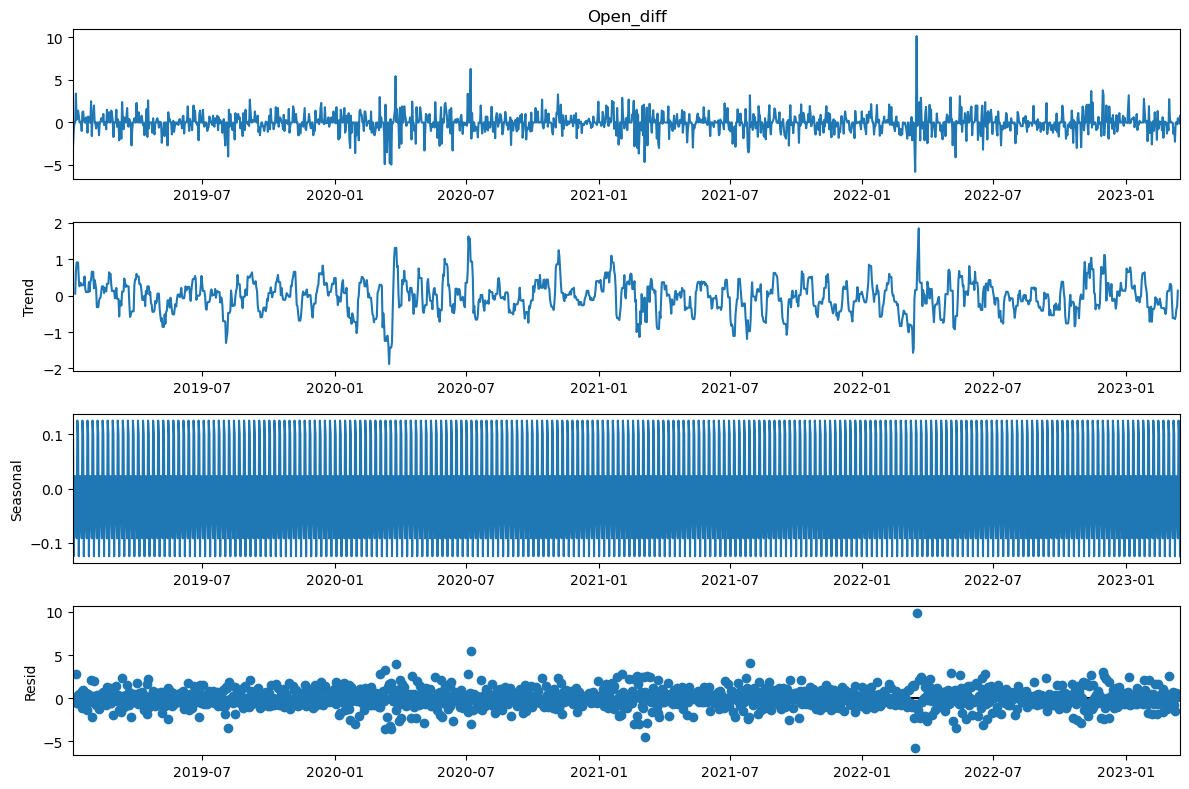

In [11]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(stock2_A["Open_diff"], model = "add")
a.plot();

#### Datos de Prueba y Entrenamiento

In [12]:
train_data = stock2['Open'][:len(stock2['Open'])-365]
test_data = stock2['Open'][len(stock2['Open'])-365:]
test=test_data.copy()
train_data.shape, test_data.shape

((1171,), (365,))

#### Modelo Auto-Arima

In [13]:
from pmdarima import auto_arima

modelo_auto=auto_arima(train_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=100, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[100]             : AIC=3960.832, Time=9.78 sec
 ARIMA(1,1,0)(1,1,0)[100]             : AIC=inf, Time=39.68 sec
 ARIMA(0,1,1)(0,1,1)[100]             : AIC=inf, Time=185.22 sec
 ARIMA(0,1,0)(1,1,0)[100]             : AIC=inf, Time=29.53 sec
 ARIMA(0,1,0)(0,1,1)[100]             : AIC=inf, Time=175.06 sec
 ARIMA(0,1,0)(1,1,1)[100]             : AIC=inf, Time=188.78 sec
 ARIMA(1,1,0)(0,1,0)[100]             : AIC=3962.180, Time=14.21 sec
 ARIMA(0,1,1)(0,1,0)[100]             : AIC=3962.203, Time=15.22 sec
 ARIMA(1,1,1)(0,1,0)[100]             : AIC=3964.029, Time=27.49 sec
 ARIMA(0,1,0)(0,1,0)[100] intercept   : AIC=3962.569, Time=13.39 sec

Best model:  ARIMA(0,1,0)(0,1,0)[100]          
Total fit time: 698.409 seconds
 ARIMA(0,1,0)(0,1,0)[100]          


In [14]:
print(modelo_auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1171
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 100)   Log Likelihood               -1979.416
Date:                             Sun, 19 Mar 2023   AIC                           3960.832
Time:                                     16:40:26   BIC                           3965.807
Sample:                                 01-02-2019   HQIC                          3962.716
                                      - 03-17-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3678      0.069     34.435      0.000       2.233       2.503
Ljung-Box (L1) (Q):        